## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [104]:
import numpy as np
from scipy.stats import qmc

In [125]:
# from scipy.stats import qmc
# Use the optimization keyword argument to produce a LHS with lower discrepancy at higher computational cost.
sampler = qmc.LatinHypercube(d=3, optimization="random-cd")
sample = sampler.random(n=200)
l_bounds = [0, 0, 0]
u_bounds = [1, 1, 1]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

In [126]:
dependent = sample_scaled[:,1].reshape(-1,1)*4+np.random.randn(200,1)
dependent_scaled = (dependent - min(dependent))/(max(dependent)-min(dependent))
sample_scaled = np.concatenate((sample_scaled, dependent_scaled), axis=1)

In [127]:
responses = np.empty((sample_scaled.shape[0], 2), dtype='float64')
responses[:, 0] = 10*sample_scaled[:,0]**2+sample_scaled[:,1]+sample_scaled[:,0]*sample_scaled[:,2]-5*sample_scaled[:,2]+sample_scaled[:,3]
responses[:, 1] = sample_scaled[:, 0] + sample_scaled[:, 1] + sample_scaled[:, 2] + sample_scaled[:, 3]

In [128]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [129]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

In [130]:
# Calculate mean sensitivity across clusters
from pyDGSA.dgsa import dgsa

sens = dgsa(sample_scaled, labels, parameter_names=['a', 'b', 'c', 'd'],
            confidence=True)
print(sens)

  0%|          | 0/3000 [00:00<?, ?it/s]

   sensitivity  confidence
a     4.058346    2.459494
b     0.843104    0.548620
c     1.429855    0.901371
d     0.912062    0.528247


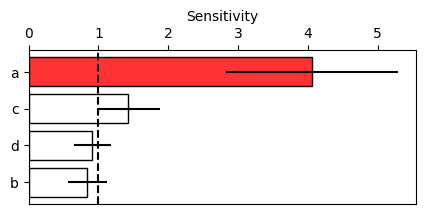

In [131]:
# Generate a pareto plot of the results
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(sens, confidence=True)

## Plots for input

In [58]:
import seaborn as sns
import pandas as pd

In [38]:

df_input = pd.DataFrame(data=(sample_scaled), columns=['a','b','c','d'])

<Axes: ylabel='Density'>

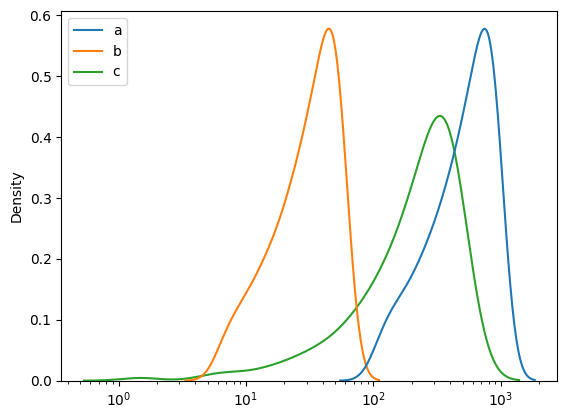

In [45]:
sns.kdeplot(data=df_input.iloc[:,0:3], log_scale=True)

<Axes: ylabel='Density'>

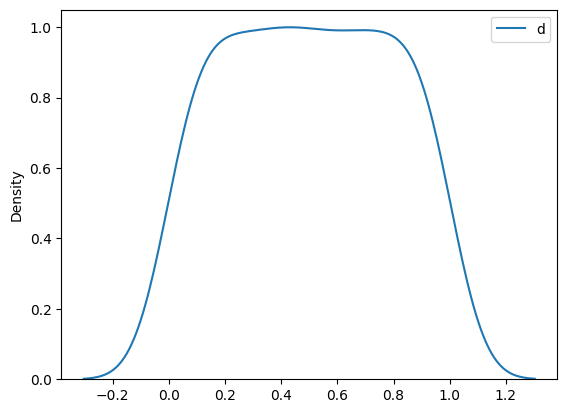

In [48]:
sns.kdeplot(data=df_input.iloc[:,3:], log_scale=False)

<Axes: ylabel='Density'>

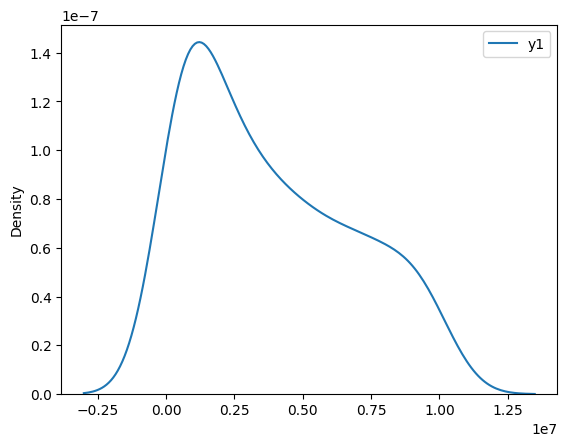

In [55]:
sns.kdeplot(data=pd.DataFrame(data=responses[:,0], columns=['y1']), log_scale=False)

<Axes: ylabel='Density'>

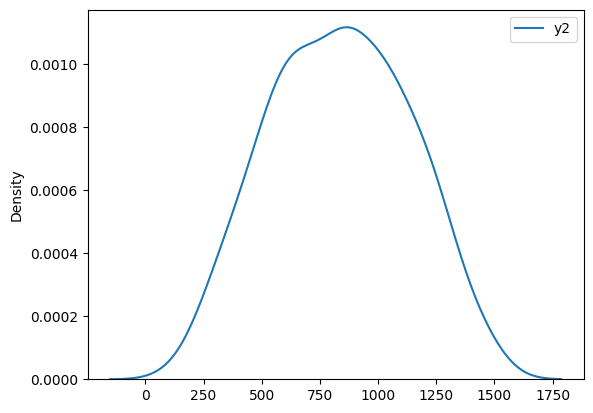

In [57]:
sns.kdeplot(data=pd.DataFrame(data=responses[:,1], columns=['y2']), log_scale=False)